# **Final Project in Data Science Course**

## **Made by Boaz Yunayev & Bar Amir**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from bs4 import BeautifulSoup
from datetime import datetime

# sklearn imports
from sklearn import linear_model
from sklearn import metrics

## Web Scraping & Crawling Using BeautifulSoup (Obtaining data)
In this section, we crawl and scrape from a website called, Steam. 
This site is a video game digital distribution service and storefront from Valve. 

We took only the `TOPSELLERS` games and created a DataFrame with specific properties.

First, we scraped game links from 360 pages (25 games each page) and then we crawled each game page, and extracted all the data we need using BeauituflSoup.

In [2]:
# We use the following properties, each column in the DataFrame represent a property
title = []
genre = []
developer = []
released_date = []
publisher = []
metacritic_score = []
steam_score_positive = []
num = []
steam_score_positive_percent = []
game_price = []
games_links = []

# Scraping and crawling 360 pages
for page in range(1, 360):
  page_url = f'https://store.steampowered.com/search/?supportedlang=english&filter=topsellers&page={page}&ndl=1'

  # Send a request to the URL and get the HTML content
  response = requests.get(page_url)
  html_content = response.content

  # Parse the HTML content with BeautifulSoup
  soup = BeautifulSoup(html_content, 'html.parser')

  search_results = soup.find(id='search_resultsRows')
  for a in search_results.find_all('a', href=True):
    if("Deck" not in (a['href'])):
      games_links.append(a['href'])


# Create a DataFrame that contain all the game links
data = {'Links': games_links}
df = pd.DataFrame(data)
df.to_csv("links.csv", index=False)



df = pd.read_csv("links.csv", index_col=False )

for game_url in df['Links']:

    response = requests.get(game_url)
    soup = BeautifulSoup(response.content, "html.parser")

# Title
    if soup.find('div', {'class': 'apphub_AppName'}) is not None:
      title.append(soup.find('div', {'class': 'apphub_AppName'}).text.strip())
    else:
       title.append("Title not found")

# Developer
    if soup.find('div', {'class': 'dev_row'}) is not None:
      developer.append(soup.find('div', {'class': 'dev_row'}).text.strip().replace("Developer:", '').strip())
    else:
      developer.append("Developer not found")

# Publisher
    if soup.find('div', {'class': 'dev_row'}).find('a') is not None:
      publisher.append(soup.find('div', {'class': 'dev_row'}).find('a').text)
    else:
      publisher.append("Publisher not found")

# Genre
    if soup.find('div', {'class': 'block_content_inner'}).find('a') is not None:
      genre.append((soup.find('div', {'class': 'block_content_inner'}).find('a').text))
    else:
      genre.append("Genre not found")

# Released Date
    if soup.find('div', {'class': 'date'}) is not None:
      released_date.append(soup.find('div', {'class': 'date'}).text.strip())
    else:
      released_date.append("Released-Date not found")

# Meta Critic Score    
    if(not len([tag.text.replace('\n', '').replace('\r', '').replace('\t', '') for tag in soup.find_all(class_="score high")]) == 0):
        metacritic_score.append(int(([tag.text.replace('\n', '').replace('\r', '').replace('\t', '') for tag in soup.find_all(class_="score high")])[-1]))
    else:
         metacritic_score.append(0)


# Game Price
    if soup.find('div', {'class': 'game_purchase_price'}) is not None:
      price_div = soup.find('div', {'class': 'game_purchase_price'})

    if price_div.text.strip() is not None:
       game_price.append(price_div.text.strip())
    else:
       game_price.append("Price not found")
      


# Score
    review_type_all = soup.find_all("span", class_="user_reviews_count")
    
    if(not len(review_type_all) == 0):
        steam_score_positive.append((review_type_all[0].text.replace("(", "").replace(")", "")))
        num.append(int(review_type_all[0].text.replace("(", "").replace(")", "").replace(",", "")))
        steam_score_positive_percent.append(int((int(review_type_all[1].text.replace("(", "").replace(")", "").replace(",", "")) / (num[-1])) * 100))
    else:
        steam_score_positive.append(0)
        steam_score_positive_percent.append(0)


----

## Here, we create the DataFrame that contains all the data we scraped

In [3]:

data = {'title': title, 'genre': genre, 'developer': developer, "released_date": released_date, "publisher": publisher, "meta_critic": metacritic_score, 
        "steam_score_positive (in thousands)": steam_score_positive, "steam_score_positive_percent (%)": steam_score_positive_percent, "game_price (₪)": game_price}

df = pd.DataFrame(data)
df.to_csv("raw_gameData.csv", index=False)

## Cleaning and Foramatting the data



In [4]:
df = pd.read_csv('raw_gameData.csv', index_col=False)

df['steam_score_positive (in thousands)'] = df['steam_score_positive (in thousands)'].str.replace(',', '').astype(int) // 100
df['released_date'] = pd.to_datetime(df['released_date'], format='%d %b, %Y', errors='coerce')
df['released_date'] = df['released_date'].dt.strftime('%Y-%m-%d')
df['game_price (₪)'] = df['game_price (₪)'].str.replace(',', '')

prices = df['game_price (₪)'].values.tolist()
for i in range(len(prices)):
    if "₪" in prices[i]:
        prices[i] = prices[i].replace("₪", "")
        prices[i] = float(prices[i])
    else:
        prices[i] = 0
    
df['game_price (₪)'] = prices


# Removing rows with ZERO value in steam_score_positivee (in thousands) column
df = df[df["steam_score_positive (in thousands)"] != 0]

# Removing metacritic_score column because it gives no indication
df.drop('meta_critic', axis=1, inplace=True)

df

,title,genre,developer,released_date,publisher,steam_score_positive (in thousands),steam_score_positive_percent (%),game_price (₪)
0,Counter-Strike: Global Offensive,Action,"Valve, Hidden Path Entertainment",2012-08-21,Valve,71065,88,0.00
1,Apex Legends™,Action,Respawn Entertainment,2020-11-04,Respawn Entertainment,6292,82,0.00
2,Resident Evil 4,Action,"CAPCOM Co., Ltd.",2023-03-23,"CAPCOM Co., Ltd.",548,97,239.00
3,New World,Action,Amazon Games,2021-09-28,Amazon Games,2530,69,149.95
4,EA SPORTS™ FIFA 23,Simulation,EA Canada & EA Romania,2022-09-29,EA Canada & EA Romania,949,50,149.95
...,...,...,...,...,...,...,...,...
8957,Oriental Dynasty - Silk Road defense war,Adventure,星环游戏,2022-12-15,星环游戏,1,59,21.95
8959,Bionic Commando,Action,Capcom,2009-07-28,Capcom,14,73,48.00
8963,Half Dead,Action,Room710Games,2016-08-01,Room710Games,32,78,7.25
8964,Super Indie Karts,Indie,One Legged Seagull,2015-05-06,One Legged Seagull,4,82,55.95


----

## Data Visualization & Proccessing

After getting all the games, we wanted to separate the genre column into binary columns of the main genres.

Each new column represents whether the game is from a specific category. We checked each game's genre for a specific word to achieve this.

In [5]:
df.to_csv("gameData.csv", index=False)
df = pd.read_csv('gameData.csv', index_col=False)

# Here, we will be adding number of columns, 
genre_names = []
genre_names = df['genre'].tolist()

is_Action = []
is_RPG = []
is_Racing = []
is_Indie = []
is_Adventure = []
is_Strategy = []
is_Casual = []
is_Simulation = []

# Checks if a word is in the string that describes all genres
for genre in df.genre:
    if("RPG" in genre):
        is_RPG.append(1)
    else:
        is_RPG.append(0)

    if("Action" in genre):
        is_Action.append(1)
    else:
        is_Action.append(0)
    
        
    if("Indie" in genre):
        is_Indie.append(1)
    else:
        is_Indie.append(0)
    
    if("Adventure" in genre):
        is_Adventure.append(1)
    else:
        is_Adventure.append(0)

    if("Strategy" in genre):
        is_Strategy.append(1)
    else:
        is_Strategy.append(0)
        
    if("Racing" in genre):
        is_Racing.append(1)
    else:
        is_Racing.append(0)
        
        
    if("Simulation" in genre):
        is_Simulation.append(1)
    else:
        is_Simulation.append(0)

    if("Casual" in genre):
        is_Casual.append(1)
    else:
        is_Casual.append(0)
        


# Creating new columns 
df["is_Action"] = is_Action
df["is_RPG"] = is_RPG
df["is_Racing"] = is_Racing
df["is_Indie"] = is_Indie
df["is_Adventure"] = is_Adventure
df["is_Strategy"] = is_Strategy
df["is_Casual"] = is_Casual
df["is_Simulation"] = is_Simulation

# df.info()

genre_names_set = set(genre_names)

# Testing

# for item in genre_names_set:
#     print(f"Genre name: {item} appears {genre_names.count(item)} times")

# Genre name: Massively Multiplayer appears 7 times
# Genre name: Audio Production appears 2 times
# Genre name: R-Age appears 1 times
# Genre name: Monolith Productions appears 1 times
# Genre name: SEGA appears 2 times
# Genre name: Action appears 1859 times
# Genre name: RPG appears 169 times
# Genre name: Volition appears 1 times
# Genre name: Education appears 1 times
# Genre name: Strategy appears 118 times
# Genre name: Laura Shigihara appears 1 times
# Genre name: Casual appears 258 times
# Genre name: Animation & Modeling appears 8 times
# Genre name: Simulation appears 176 times
# Genre name: Sports appears 7 times
# Genre name: Bethesda Game Studios® appears 1 times
# Genre name: Design & Illustration appears 3 times
# Genre name: Adventure appears 590 times
# Genre name: Free to Play appears 65 times
# Genre name: Early Access appears 1 times
# Genre name: Utilities appears 12 times
# Genre name: Indie appears 315 times
# Genre name: Racing appears 45 times
# Genre name: Rusty Lake appears 1 times

# We decided to take genres that appear more than 40

average_score = df['steam_score_positive_percent (%)'].mean()
print("Average Steam Score Positive Percent: {:.2f}%".format(average_score))

df.to_csv("gameData.csv", index=False)

# Shows new columns
df[['is_Action' ,'is_RPG' , "is_Racing" , "is_Indie", "is_Adventure", "is_Strategy", "is_Casual", "is_Simulation"]]


Average Steam Score Positive Percent: 81.38%


,is_Action,is_RPG,is_Racing,is_Indie,is_Adventure,is_Strategy,is_Casual,is_Simulation
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
6532,0,0,0,0,1,0,0,0
6533,1,0,0,0,0,0,0,0
6534,1,0,0,0,0,0,0,0
6535,0,0,0,1,0,0,0,0


----

### Here, we add 2 more columns
We create 2 columns, "is_Successful" and "is_Free". 

In [6]:
is_Successful = []
is_Free = []

for index, row in df.iterrows():
    score = row["steam_score_positive (in thousands)"]
    score_percent = row["steam_score_positive_percent (%)"]

    if(score_percent > 60):
        is_Successful.append(1)
    else:
        is_Successful.append(0)


for price in df["game_price (₪)"]:
    if(price == 0):
        is_Free.append(1)
    else:
        is_Free.append(0)


print(f"Amount of successful games: {is_Successful.count(1)}")
print(f"Amount of unsuccessful games: {is_Successful.count(0)}")

# Creating 2 more columns
df["is_Successful"] = is_Successful
df["is_Free"] = is_Free

df.describe()
df.to_csv("gameData.csv", index=False)
df.head()


Amount of successful games: 5935
Amount of unsuccessful games: 602


,title,genre,developer,released_date,publisher,steam_score_positive (in thousands),steam_score_positive_percent (%),game_price (₪),is_Action,is_RPG,is_Racing,is_Indie,is_Adventure,is_Strategy,is_Casual,is_Simulation,is_Successful,is_Free
0,Counter-Strike: Global Offensive,Action,"Valve, Hidden Path Entertainment",2012-08-21,Valve,71065,88,0.00,1,0,0,0,0,0,0,0,1,1
1,Apex Legends™,Action,Respawn Entertainment,2020-11-04,Respawn Entertainment,6292,82,0.00,1,0,0,0,0,0,0,0,1,1
2,Resident Evil 4,Action,"CAPCOM Co., Ltd.",2023-03-23,"CAPCOM Co., Ltd.",548,97,239.00,1,0,0,0,0,0,0,0,1,0
3,New World,Action,Amazon Games,2021-09-28,Amazon Games,2530,69,149.95,1,0,0,0,0,0,0,0,1,0
4,EA SPORTS™ FIFA 23,Simulation,EA Canada & EA Romania,2022-09-29,EA Canada & EA Romania,949,50,149.95,0,0,0,0,0,0,0,1,0,0


----

## Visualization

### This is the representation of GENRE CATEGORY

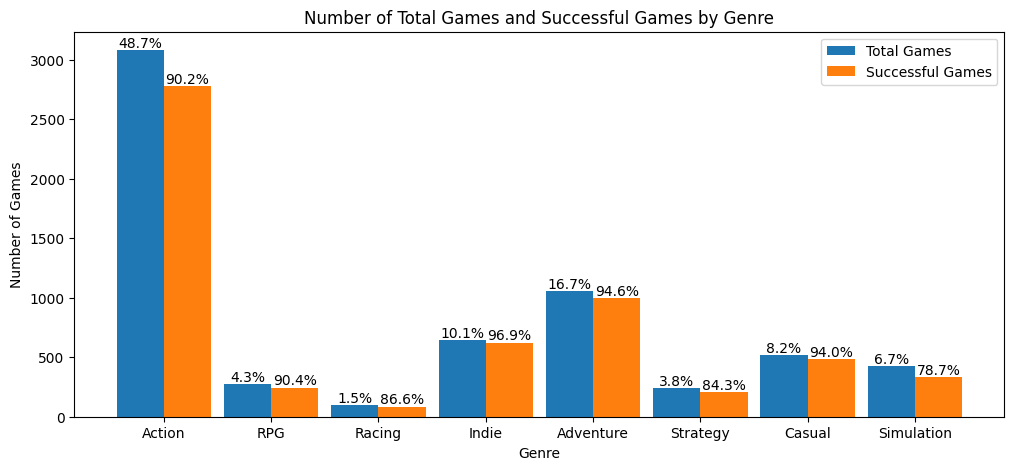

In [7]:
fig = plt.figure(figsize=(12, 5))
names = ["Action", "RPG", "Racing", "Indie", "Adventure", "Strategy", "Casual", "Simulation"]
total_scores = [len(df[df.is_Action == 1]),
                len(df[df.is_RPG == 1]),
                len(df[df.is_Racing == 1]),
                len(df[df.is_Indie == 1]),
                len(df[df.is_Adventure == 1]),
                len(df[df.is_Strategy == 1]),
                len(df[df.is_Casual == 1]),
                len(df[df.is_Simulation == 1])]
successful_scores = [len(df[(df.is_Action == 1) & (df.is_Successful == 1)]),
                     len(df[(df.is_RPG == 1) & (df.is_Successful == 1)]),
                     len(df[(df.is_Racing == 1) & (df.is_Successful == 1)]),
                     len(df[(df.is_Indie == 1) & (df.is_Successful == 1)]),
                     len(df[(df.is_Adventure == 1) & (df.is_Successful == 1)]),
                     len(df[(df.is_Strategy == 1) & (df.is_Successful == 1)]),
                     len(df[(df.is_Casual == 1) & (df.is_Successful == 1)]),
                     len(df[(df.is_Simulation == 1) & (df.is_Successful == 1)])]
positions = [0, 1, 2, 3, 4, 5, 6, 7]

width = 0.44

plt.bar(positions, total_scores, width=width, label='Total Games')
plt.bar([p + width for p in positions], successful_scores, width=width, label='Successful Games')

for i, (total, successful) in enumerate(zip(total_scores, successful_scores)):
    total_percentage = total / sum(total_scores) * 100
    successful_percentage = successful / total * 100
    plt.text(positions[i], total, f'{total_percentage:.1f}%', ha='center', va='bottom')
    plt.text(positions[i] + width, successful, f'{successful_percentage:.1f}%', ha='center', va='bottom')

plt.xticks([p + width / 2 for p in positions], names)
plt.xlabel('Genre')
plt.ylabel('Number of Games')
plt.title('Number of Total Games and Successful Games by Genre')
plt.legend()

plt.show()



We can see above that the main genre is Action. In addition, we can see the percentage of the most successful games of all games from the same genre.

----

### This is the representation of games release on each month of the year

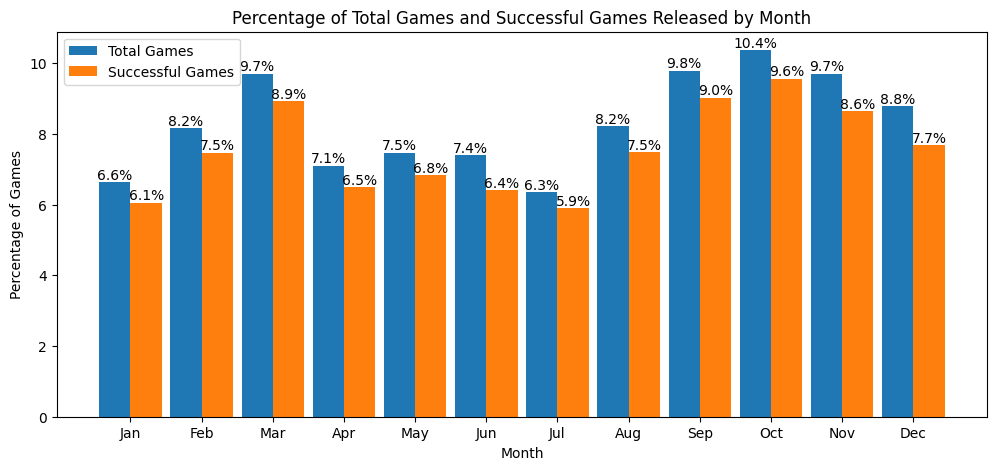

In [8]:
fig = plt.figure(figsize=(12, 5))
months = pd.to_datetime(df['released_date']).dt.month
names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
total_games = len(df)  # Total number of games
total_scores = [(months[months == i].count() / total_games) * 100 for i in range(1, 13)]
successful_scores = [(months[(months == i) & (df['is_Successful'] == 1)].count() / total_games) * 100 for i in range(1, 13)]
positions = range(1, 13)
width = 0.44

plt.bar(positions, total_scores, width=width, label='Total Games')
plt.bar([p + width for p in positions], successful_scores, width=width, label='Successful Games')

for i, (total, successful) in enumerate(zip(total_scores, successful_scores)):
    plt.text(positions[i], total, f'{total:.1f}%', ha='center', va='bottom')
    plt.text(positions[i] + width, successful, f'{successful:.1f}%', ha='center', va='bottom')

plt.xticks([p + width / 2 for p in positions], names)
plt.xlabel('Month')
plt.ylabel('Percentage of Games')
plt.title('Percentage of Total Games and Successful Games Released by Month')
plt.legend()

plt.show()

We can see above that most games are released on September, October and November. Moreover, we can see that the most successful games are also released on the same months.

----

### Representation of `Paid vs. Free` games

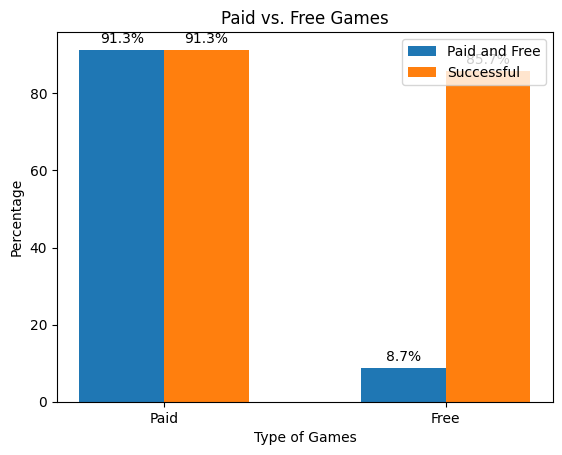

In [9]:
free_counts = df['is_Free'].value_counts()

# Calculate the percentages
total_games = free_counts.sum()
percentages = free_counts / total_games * 100

# Calculate the percentage of successful games out of all games
successful_games = df[df['is_Successful'] == 1]['is_Free'].value_counts()
successful_percentages = successful_games / free_counts * 100

# Plot a bar graph of the free and paid percentages
labels = ['Paid', 'Free']
percentages = percentages.values

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, percentages, width, label='Paid and Free')
rects2 = ax.bar(x + width/2, successful_percentages, width, label='Successful')

ax.set_title("Paid vs. Free Games")
ax.set_xlabel("Type of Games")
ax.set_ylabel("Percentage")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add percentage labels on top of each bar
for rect1, rect2 in zip(rects1, rects2):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    ax.annotate(f"{height1:.1f}%", xy=(rect1.get_x() + rect1.get_width() / 2, height1), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')
    ax.annotate(f"{height2:.1f}%", xy=(rect2.get_x() + rect2.get_width() / 2, height2), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')

plt.show()

We can see above that most of the games are not free. Moreover, we can the percentage of the successful games of each bar.

----

In [10]:
df.head()

,title,genre,developer,released_date,publisher,steam_score_positive (in thousands),steam_score_positive_percent (%),game_price (₪),is_Action,is_RPG,is_Racing,is_Indie,is_Adventure,is_Strategy,is_Casual,is_Simulation,is_Successful,is_Free
0,Counter-Strike: Global Offensive,Action,"Valve, Hidden Path Entertainment",2012-08-21,Valve,71065,88,0.00,1,0,0,0,0,0,0,0,1,1
1,Apex Legends™,Action,Respawn Entertainment,2020-11-04,Respawn Entertainment,6292,82,0.00,1,0,0,0,0,0,0,0,1,1
2,Resident Evil 4,Action,"CAPCOM Co., Ltd.",2023-03-23,"CAPCOM Co., Ltd.",548,97,239.00,1,0,0,0,0,0,0,0,1,0
3,New World,Action,Amazon Games,2021-09-28,Amazon Games,2530,69,149.95,1,0,0,0,0,0,0,0,1,0
4,EA SPORTS™ FIFA 23,Simulation,EA Canada & EA Romania,2022-09-29,EA Canada & EA Romania,949,50,149.95,0,0,0,0,0,0,0,1,0,0


### Representation of the correlation between publishers and successful games

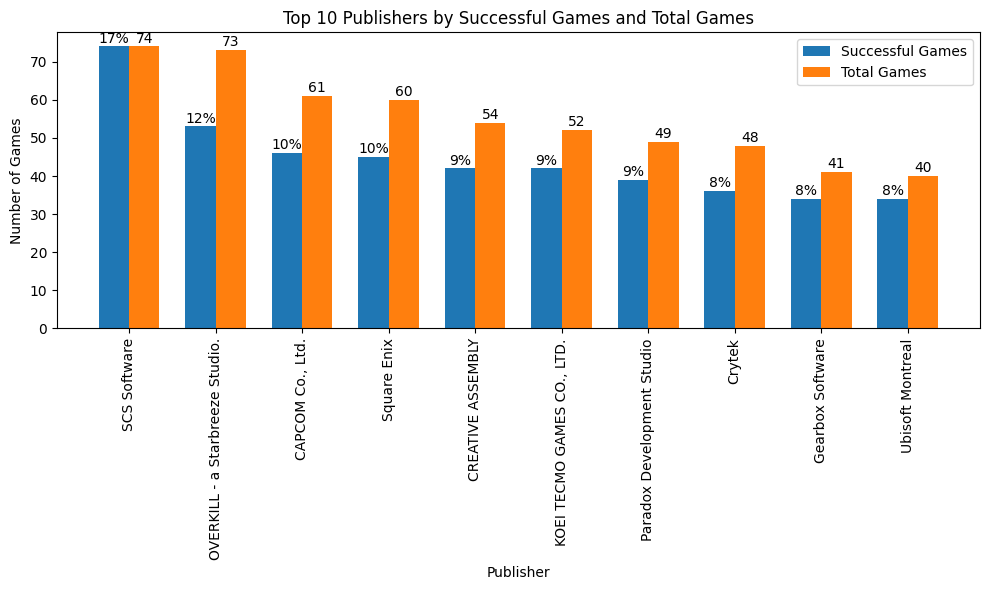

In [11]:

success_counts = df[df['is_Successful'] == 1].groupby('publisher').size().sort_values(ascending=False)[:10]
total_counts = df.groupby('publisher').size().sort_values(ascending=False)[:10]

total_success = success_counts.sum()
total_games = total_counts.sum()

# Calculate the percentage for each publisher
success_percentage = (success_counts / total_success) * 100

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(success_counts))

# Plot the bar for successful games
ax.bar(index, success_counts, bar_width, label='Successful Games')

# Plot the bar for total games
ax.bar([i + bar_width for i in index], total_counts, bar_width, label='Total Games')

# Add the percentage labels to each bar for successful games
for i, v in enumerate(success_counts):
    percentage_label = f"{success_percentage.iloc[i]:.0f}%"
    ax.text(i, v + 1, percentage_label, ha='center', color='black')

# Add the count labels to each bar for total games
for i, v in enumerate(total_counts):
    ax.text(i + bar_width, v + 1, str(v), ha='center', color='black')

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(success_counts.index, rotation=90)

# Set the title and axis labels
plt.title('Top 10 Publishers by Successful Games and Total Games')
plt.xlabel('Publisher')
plt.ylabel('Number of Games')

# Show the legend
plt.legend()



# Show the graph
plt.tight_layout()
plt.show()

We can see above that most of the successful games are released by SCS Software, Ubisoft Montreal, Crytek and more.

----

### Representation of correlation between successful games and its price

In [12]:

import plotly.express as px

# Assuming your dataset is stored in a Pandas DataFrame called 'df'
fig = px.scatter(df, x='game_price (₪)', y='steam_score_positive_percent (%)',
                 hover_data=['title', 'genre', 'developer', 'released_date', 'publisher'],
                 color='is_Successful')

fig.update_layout(
    title='Game Success Visualization',
    xaxis_title='Game Price (₪)',
    yaxis_title='Steam Score Positive Percent (%)'
)

fig.show()

We can see above points to view detailed information about specific games, such as genre, developer, release date, and success status.

You can hover over the data to see more details.

----

## Machine Learning

Here, we reformat few columns to improve out accuracy on prediction.

Convert developers and publishers into numeric type instead of categorical type

In [13]:
df_numeric = df.copy()

df_numeric["developer"] = pd.factorize(df.developer)[0]
df_numeric["publisher"] = pd.factorize(df.publisher)[0]

## Shows each column's type
# for column, dtype in df_numeric.iteritems():
#     if np.issubdtype(dtype, np.number):
#         print(f"{column}: Numeric")
#     else:
#         print(f"{column}: Categorical")

df_numeric['released_date'] = pd.to_datetime(df['released_date'])

df_numeric['month'] = df_numeric['released_date'].dt.month
df_numeric['month'] = df_numeric['month'].fillna(-1)
df_numeric = df_numeric.drop(df_numeric[df_numeric['month'] == -1].index)
df_numeric['month'] = df_numeric['month'].astype(int)

df_numeric['year'] = df_numeric['released_date'].dt.year
df_numeric['year'] = df_numeric['year'].fillna(-1)
df_numeric = df_numeric.drop(df_numeric[df_numeric['year'] == -1].index)
df_numeric['year'] = df_numeric['year'].astype(int)

df_numeric



,title,genre,developer,released_date,publisher,steam_score_positive (in thousands),steam_score_positive_percent (%),game_price (₪),is_Action,is_RPG,is_Racing,is_Indie,is_Adventure,is_Strategy,is_Casual,is_Simulation,is_Successful,is_Free,month,year
0,Counter-Strike: Global Offensive,Action,0,2012-08-21,0,71065,88,0.00,1,0,0,0,0,0,0,0,1,1,8,2012
1,Apex Legends™,Action,1,2020-11-04,1,6292,82,0.00,1,0,0,0,0,0,0,0,1,1,11,2020
2,Resident Evil 4,Action,2,2023-03-23,2,548,97,239.00,1,0,0,0,0,0,0,0,1,0,3,2023
3,New World,Action,3,2021-09-28,3,2530,69,149.95,1,0,0,0,0,0,0,0,1,0,9,2021
4,EA SPORTS™ FIFA 23,Simulation,4,2022-09-29,4,949,50,149.95,0,0,0,0,0,0,0,1,0,0,9,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6532,Oriental Dynasty - Silk Road defense war,Adventure,3703,2022-12-15,3469,1,59,21.95,0,0,0,0,1,0,0,0,0,0,12,2022
6533,Bionic Commando,Action,256,2009-07-28,239,14,73,48.00,1,0,0,0,0,0,0,0,1,0,7,2009
6534,Half Dead,Action,2070,2016-08-01,1944,32,78,7.25,1,0,0,0,0,0,0,0,1,0,8,2016
6535,Super Indie Karts,Indie,3704,2015-05-06,3470,4,82,55.95,0,0,0,1,0,0,0,0,1,0,5,2015


----

### Logistic Regression

In [14]:
# Select the relevant features and target variable
features = ["game_price (₪)",'is_Free', 'is_Action', 'is_RPG', 'is_Racing', 'is_Indie', 'is_Adventure', 'is_Strategy', 'is_Casual', 'is_Simulation', 'publisher', 'developer', 'year', 'month']
target = 'is_Successful'

# Convert categorical features into numerical using OneHotEncoding

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_numeric[features], df_numeric[target], test_size=0.2, random_state=42)

# Create and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = model.predict(X_test)


# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.9132770529547198


----

### Random Forests

In [15]:
# Train a random forest classifier on the training data
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = rf.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.9140445126630852


----

### Decision Trees

In [16]:
# create the decision tree classifier
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8357636224098235


----

### Naive Bayes

In [17]:
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions on the test set 
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7989255564082886


----

### SVM

In [18]:
# Step 3: Training the SVM model
svm = SVC()
svm.fit(X_train, y_train)

# Step 4: Evaluating the model
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9132770529547198


----

## Conclusions

We managed to predict whether a game will be successful or not based on specific properties.


The accuracy of Logistic Regression was `91%` correct.

The accuracy of Random Forests was `91%` correct.

The accuracy of Decision Trees was `84%` correct.

The accuracy of Multinomial Naive Bayes was `80%` correct.

The accuracy of SVM was `91%` correct.

This project can help publishers to predict whether their game will be successful or not.


### `By: Boaz Yunayev & Bar Amir`